In [1]:
# !pip install -q -U tensorflow
# !pip install -q tensorflow_datasets

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'

In [36]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This is my first comment on IMDb website, and the reason I'm writing it is that we're talking about ONE OF THE BEST FILMS EVER! 'Ne goryuy!' will make you laugh and cry at the same time, you will fall in love (if you're not a fan yet!) with Georgian choir singing tradition, and possibly you will accept the hardships of your own existence and just feel good after watching it:) What I like a lot about this film is that actors in the non-leading roles create vivid and memorable characters and are just as interesting and important as the central character. The film is starring Vahtang Kikabidze (who is great), but you will remember every single face around him in the film. You will find yourself quoting their lines, that have become household names for so many Russian-speaking people. A film to live with. Simple, yet deep, you will want to watch it again and again."
 b'McConaughey in a horror/thriller? I had to see this. I was pleasantly surprised.<br /><br />The plot is told in

In [37]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [38]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [39]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,  56, ...,   0,   0,   0],
       [  1,   8,   4, ...,   0,   0,   0],
       [ 10,  63, 492, ...,   0,   0,   0]])

In [40]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is my first comment on IMDb website, and the reason I'm writing it is that we're talking about ONE OF THE BEST FILMS EVER! 'Ne goryuy!' will make you laugh and cry at the same time, you will fall in love (if you're not a fan yet!) with Georgian choir singing tradition, and possibly you will accept the hardships of your own existence and just feel good after watching it:) What I like a lot about this film is that actors in the non-leading roles create vivid and memorable characters and are just as interesting and important as the central character. The film is starring Vahtang Kikabidze (who is great), but you will remember every single face around him in the film. You will find yourself quoting their lines, that have become household names for so many Russian-speaking people. A film to live with. Simple, yet deep, you will want to watch it again and again."
Round-trip:  this is my first comment on imdb [UNK] and the reason im writing it is that were talking about one 

In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [47]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 198s 455ms/step - loss: 0.6845 - accuracy: 0.5055 - val_loss: 0.4639 - val_accuracy: 0.8016
Epoch 2/20
391/391 [==============================] - 171s 436ms/step - loss: 0.4380 - accuracy: 0.8109 - val_loss: 0.3732 - val_accuracy: 0.8266
Epoch 3/20
391/391 [==============================] - 171s 436ms/step - loss: 0.3547 - accuracy: 0.8506 - val_loss: 0.3372 - val_accuracy: 0.8490
Epoch 4/20
391/391 [==============================] - 169s 430ms/step - loss: 0.3330 - accuracy: 0.8595 - val_loss: 0.3290 - val_accuracy: 0.8469
Epoch 5/20
391/391 [==============================] - 169s 430ms/step - loss: 0.3184 - accuracy: 0.8662 - val_loss: 0.3221 - val_accuracy: 0.8547
Epoch 6/20
391/391 [==============================] - 170s 433ms/step - loss: 0.3132 - accuracy: 0.8683 - val_loss: 0.3199 - val_accuracy: 0.8583
Epoch 7/20
391/391 [==============================] - 170s 433ms/step - loss: 0.3075 - accuracy: 0.8663 - val_loss: 0.3210 -

In [48]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.6898892]]


In [57]:
# predict on a sample text without padding.

sample_text = ('The movie was very good. The animation and the graphics '
                    'were great. I would  recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.2804651]]


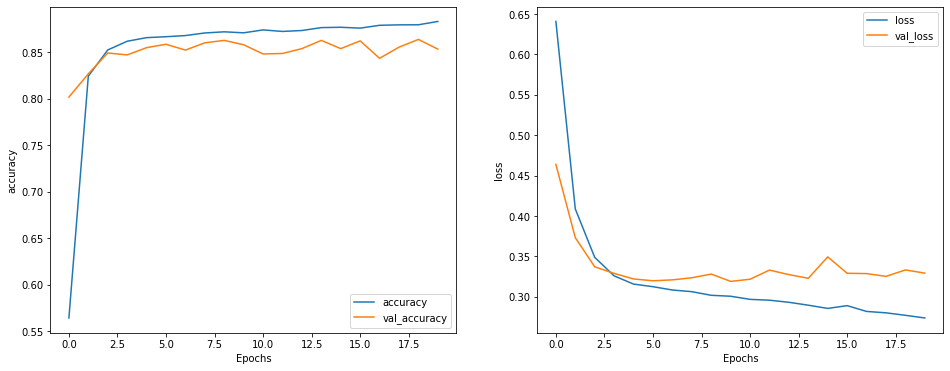

In [49]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')